In [50]:
import pandas as pd
import numpy as np
from collections import Counter
from multiprocessing import cpu_count
from joblib import Parallel, delayed
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.dummy import DummyClassifier

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

import matplotlib.pyplot as plt

#from nlpretext import Preprocessor
#from nlpretext.basic.preprocess import normalize_whitespace, remove_punct, remove_eol_characters, remove_stopwords, \
#   lower_text, remove_accents, remove_multiple_spaces_and_strip_text, replace_numbers, replace_emails, replace_urls
#from nlpretext.social.preprocess import remove_mentions, remove_hashtag, remove_emoji

# some useful libraries
# spacy

np.random.seed(42)

In [3]:
train_data = pd.read_csv("./train.csv")
test_data = pd.read_csv("./test.csv")

In [4]:
print(train_data.shape)
train_data["text"][5]

(7613, 5)


'#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires'

In [4]:
# text pre-processing
def clean_text(text):
    preprocessor = Preprocessor()
    preprocessor.pipe(lower_text)
    preprocessor.pipe(remove_mentions)
    preprocessor.pipe(remove_hashtag)
    preprocessor.pipe(remove_emoji)
    preprocessor.pipe(remove_eol_characters)
    preprocessor.pipe(remove_stopwords, args={'lang': 'en'})
    preprocessor.pipe(remove_punct)
    preprocessor.pipe(replace_urls)
    preprocessor.pipe(replace_emails)
    preprocessor.pipe(replace_numbers)
    preprocessor.pipe(remove_accents)
    preprocessor.pipe(remove_multiple_spaces_and_strip_text)
    preprocessor.pipe(normalize_whitespace)

    text = preprocessor.run(text)

    return text

In [6]:
train_data['clean_text'] = train_data.text.apply(lambda x: clean_text(x))
print(train_data.head())
train_data.to_csv('train_clean.csv')

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target                                         clean_text  
0       1                         deeds reason allah forgive  
1       1                   forest fire la ronge sask canada  
2       1  residents asked shelter place notified officer...  
3       1  *NUMBER people receive evacuation orders calif...  
4       1                      photo ruby smoke pours school  


In [28]:
train_data_clean = pd.read_csv("./train_clean.csv")
cleaned_train_text = list(train_data_clean["clean_text"])

In [29]:
train_data_clean.shape

(7613, 7)

In [30]:
train_data_clean[train_data_clean['clean_text'].isna()].index


Int64Index([832, 1664, 3680, 4297, 4891, 5564], dtype='int64')

In [31]:
train_data_clean = train_data_clean.drop(train_data_clean[train_data_clean['clean_text'].isna()].index)
print(train_data_clean.shape)

(7607, 7)


In [33]:
cleaned_train_text = list(train_data_clean["clean_text"])

In [34]:
d = set()
for s in cleaned_train_text:
    if type(s) is float:
        print(s)
    d.add(type(s))
print(d)

{<class 'str'>}


In [37]:
labels = list(train_data_clean["target"])

In [39]:
maxlen = 100
training_samples = 200
validation_samples = 10000
max_words = 10000
vocab_size = 1000
# word level one-hot encoding
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(cleaned_train_text)
sequences = tokenizer.texts_to_sequences(cleaned_train_text)
one_hot_results = tokenizer.texts_to_matrix(cleaned_train_text, mode='binary')
word_index = tokenizer.word_index
print(f"Found {len(word_index)} unique tokens")

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)


Found 17597 unique tokens
Shape of data tensor: (7607, 100)
Shape of label tensor: (7607,)


In [40]:
# model taken from notes
inputs = keras.Input(shape=(None,))
embed_layer = keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=300,
        mask_zero=True
    )(inputs)
x = keras.layers.Bidirectional(keras.layers.LSTM(64))(embed_layer)
x = keras.layers.Dense(64, activation='relu')(x)
outputs = keras.layers.Dense(units=5, activation='softmax')(x)

model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics="accuracy")

model.fit(data, labels, validation_split=0.3, epochs=5, batch_size=64)

Epoch 1/5
84/84 [==============================] - 20s 173ms/step - loss: 0.7227 - accuracy: 0.6634 - val_loss: 0.5804 - val_accuracy: 0.7179
Epoch 2/5
84/84 [==============================] - 13s 155ms/step - loss: 0.4619 - accuracy: 0.7964 - val_loss: 0.5434 - val_accuracy: 0.7376
Epoch 3/5
84/84 [==============================] - 13s 159ms/step - loss: 0.4189 - accuracy: 0.8157 - val_loss: 0.5266 - val_accuracy: 0.7416
Epoch 4/5
84/84 [==============================] - 13s 151ms/step - loss: 0.3955 - accuracy: 0.8293 - val_loss: 0.5600 - val_accuracy: 0.7162
Epoch 5/5
84/84 [==============================] - 13s 153ms/step - loss: 0.3723 - accuracy: 0.8415 - val_loss: 0.5586 - val_accuracy: 0.7332


In [45]:
# trying recurrent layer
model2 = keras.models.Sequential()
model2.add(layers.Embedding(max_words, 32))
model2.add(layers.SimpleRNN(32))
model2.add(layers.Dense(1, activation='sigmoid'))
model2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics="accuracy")
history = model2.fit(data, labels, validation_split=0.3, epochs=5, batch_size=64)

Epoch 1/5
84/84 [==============================] - 2s 20ms/step - loss: 0.6415 - accuracy: 0.6319 - val_loss: 0.5880 - val_accuracy: 0.7109
Epoch 2/5
84/84 [==============================] - 2s 18ms/step - loss: 0.5290 - accuracy: 0.7545 - val_loss: 0.5893 - val_accuracy: 0.6956
Epoch 3/5
84/84 [==============================] - 2s 20ms/step - loss: 0.4676 - accuracy: 0.7821 - val_loss: 0.5226 - val_accuracy: 0.7503
Epoch 4/5
84/84 [==============================] - 2s 20ms/step - loss: 0.3996 - accuracy: 0.8197 - val_loss: 0.5108 - val_accuracy: 0.7551
Epoch 5/5
84/84 [==============================] - 2s 20ms/step - loss: 0.3655 - accuracy: 0.8372 - val_loss: 0.5172 - val_accuracy: 0.7569


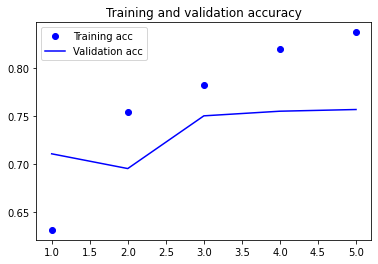

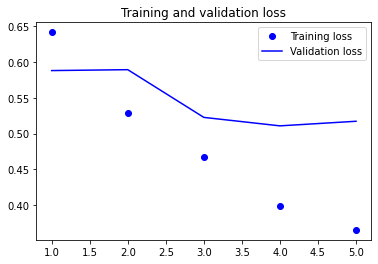

In [51]:
# plotting the model fit
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
# before running this, need to clean the test today
# evaluate the model on the test data
test_evals = model.evaluate(test_x_pad, test_y)
print(test_evals)
# predict on the test data
predictions = model.predict(test_x_pad)
predicted_lbls = np.argmax(predictions, axis=1)
cr = classification_report(test_y, predicted_lbls)
print(cr)

In [52]:
# using LSTM layer
model3 = keras.models.Sequential()
model3.add(layers.Embedding(max_words, 32))
model3.add(layers.LSTM(32))
model3.add(layers.Dense(1, activation='sigmoid'))
model3.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics="accuracy")
history2 = model2.fit(data, labels, validation_split=0.3, epochs=5, batch_size=64)

Epoch 1/5
84/84 [==============================] - 2s 19ms/step - loss: 0.3290 - accuracy: 0.8616 - val_loss: 0.5376 - val_accuracy: 0.7473
Epoch 2/5
84/84 [==============================] - 2s 20ms/step - loss: 0.3189 - accuracy: 0.8706 - val_loss: 0.5602 - val_accuracy: 0.7451
Epoch 3/5
84/84 [==============================] - 2s 20ms/step - loss: 0.3042 - accuracy: 0.8725 - val_loss: 0.5975 - val_accuracy: 0.7122
Epoch 4/5
84/84 [==============================] - 2s 18ms/step - loss: 0.2717 - accuracy: 0.8929 - val_loss: 0.6363 - val_accuracy: 0.7017
Epoch 5/5
84/84 [==============================] - 2s 19ms/step - loss: 0.2468 - accuracy: 0.9040 - val_loss: 0.6466 - val_accuracy: 0.7127


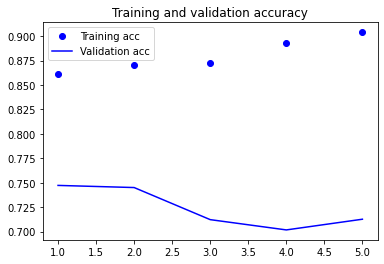

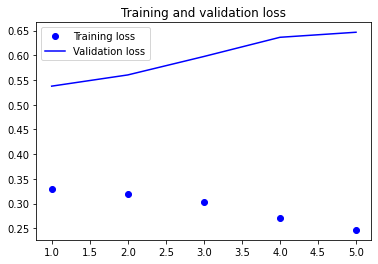

In [53]:
# plotting the model fit
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()